<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter08/focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://github.com/hitachi-rd-cv/CDB-loss/tree/143ea5c17c237c71cfbf0a7f2df66a4009394cdc

In [33]:
# import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

torch.manual_seed(42)
random.seed(0)
num_classes = 10

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(10, shear=10)] + test_seq)
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)

train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, transform=test_transform),
    batch_size=1000, shuffle=True)



In [34]:
train_subset.dataset.train_labels
# new_trainset_split.dataset.targets

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [35]:
# train_subset[0]

In [36]:
# create imbalanced data
torch.manual_seed(42)
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)

In [37]:
# create imbalanced data
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)

idx_to_del = [i for i, label in enumerate(train_subset.dataset.train_labels) 
              if random.random() > sample_probs[label]]

imbalanced_train_dataset = copy.deepcopy(train_dataset)
imbalanced_train_dataset.targets = np.delete(train_subset.dataset.targets, idx_to_del, axis=0)
imbalanced_train_dataset.data = np.delete(train_subset.dataset.data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True, **kwargs)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Original dataset: 50000 training samples & 10000 testing samples

Distribution of classes in original dataset:


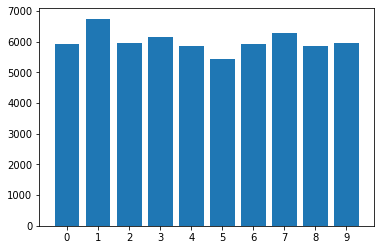

Sampling probability for each class:


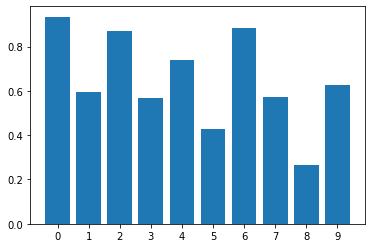

Imbalanced dataset: 39154 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


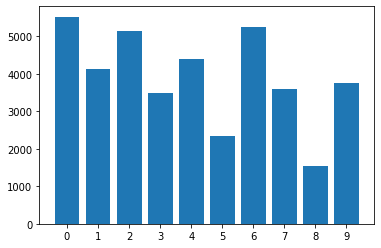

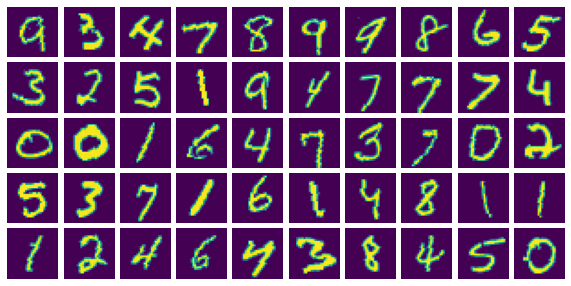

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
        
    
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
        
        
print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_subset.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break
    

In [39]:
from collections import Counter
Counter(imbalanced_train_dataset.train_labels.numpy())

Counter({0: 5520,
         4: 4382,
         1: 4120,
         9: 3764,
         2: 5149,
         3: 3489,
         6: 5257,
         7: 3601,
         5: 2332,
         8: 1540})

In [40]:
def validate(model, val_dataloader, val_samples_per_class):
     model.eval()
     val_total = 0
     val_loss = 0
     class_wise_accuracy = np.zeros(10) # number of classes = 10
     valloader = val_dataloader
     for val_images, val_labels in valloader:
          val_images = val_images.to(device)
          val_labels = val_labels.to(device)
          with torch.no_grad():
               out = model(val_images)
          _, val_predicted = out.max(1)
          val_total += val_labels.size(0)
          for id in range(len(val_predicted)): 
             if val_predicted[id] == val_labels[id]:
                 class_wise_accuracy[int(val_predicted[id])] += 1
     
     print('class_wise_accuracy is: ', class_wise_accuracy)
     class_wise_accuracy = class_wise_accuracy/val_samples_per_class
     print('after normalization, class_wise_accuracy is: ', class_wise_accuracy)
     return class_wise_accuracy


In [62]:
from collections import Counter 

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
def process(train_loader, test_loader, lossCriterion, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    if lossCriterion == torch.nn.NLLLoss:
      print('loss is torch.nn.NLLLoss')
      criterion = lossCriterion()
    else:
      class_difficulty = np.ones(num_classes)
      criterion = lossCriterion(class_difficulty, tau = 2.0)

    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()  

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(1, 10 + 1):
        train(train_loader)

        class_wise_accuracy = validate(model, val_loader, val_samples_per_class=25)

        if lossCriterion == ClassDifficultyBalancedLoss:
          loss = ClassDifficultyBalancedLoss(class_difficulty = 1 - class_wise_accuracy, tau = 2.0) #tau =  0.5, 1, 1.5, 2, 5,

        val_accuracy = class_wise_accuracy.mean()
        print('Validation: val accuracy = %.4f' % (val_accuracy))

        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))
        
    vis(test_accs, confusion_mtxes, classe_labels)

loss is torch.nn.NLLLoss
Validation: val accuracy = 33.7600
Best test acc = 85.93%
Validation: val accuracy = 36.5040
Best test acc = 92.37%
Validation: val accuracy = 37.6720
Best test acc = 95.02%
Validation: val accuracy = 37.7920
Best test acc = 95.71%
Validation: val accuracy = 37.9600
Best test acc = 96.06%
Validation: val accuracy = 38.2360
Best test acc = 96.51%
Validation: val accuracy = 38.3680
Best test acc = 96.71%
Validation: val accuracy = 38.4720
Best test acc = 97.18%
Validation: val accuracy = 38.4840
Best test acc = 97.22%
Validation: val accuracy = 38.5520
Best test acc = 97.51%


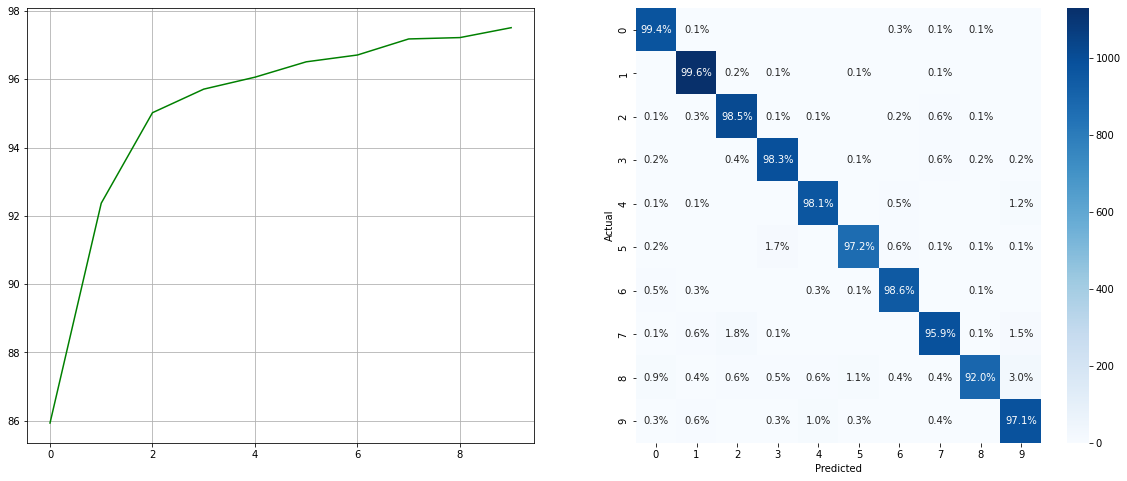

In [22]:
# baseline of torch.nn.CrossEntropyLoss
process(imbalanced_train_loader, test_loader, torch.nn.NLLLoss)

In [63]:
class ClassDifficultyBalancedLoss(torch.nn.Module):
    def __init__(self, class_difficulty, tau):
        super().__init__()
        self.class_difficulty = class_difficulty
        self.weights = self.class_difficulty ** float(tau)
        self.weights = self.weights / self.weights.sum() * len(self.weights)
        self.loss = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(self.weights))
        
    def forward(self, input: torch.Tensor, target: torch.Tensor):
        return self.loss(input, target)

class_wise_accuracy is:  [1005. 1105.  940.  891.  915.  748.  948.  904.  501.  900.]
after normalization, class_wise_accuracy is:  [40.2  44.2  37.6  35.64 36.6  29.92 37.92 36.16 20.04 36.  ]
Validation: val accuracy = 35.4280
Best test acc = 89.72%
class_wise_accuracy is:  [1001. 1125.  946.  928.  964.  805.  958.  957.  683.  875.]
after normalization, class_wise_accuracy is:  [40.04 45.   37.84 37.12 38.56 32.2  38.32 38.28 27.32 35.  ]
Validation: val accuracy = 36.9680
Best test acc = 94.05%
class_wise_accuracy is:  [1006. 1127.  952.  923.  961.  834.  965.  969.  810.  896.]
after normalization, class_wise_accuracy is:  [40.24 45.08 38.08 36.92 38.44 33.36 38.6  38.76 32.4  35.84]
Validation: val accuracy = 37.7720
Best test acc = 95.35%
class_wise_accuracy is:  [1006. 1125.  953.  928.  969.  840.  968.  990.  847.  906.]
after normalization, class_wise_accuracy is:  [40.24 45.   38.12 37.12 38.76 33.6  38.72 39.6  33.88 36.24]
Validation: val accuracy = 38.1280
Best test a

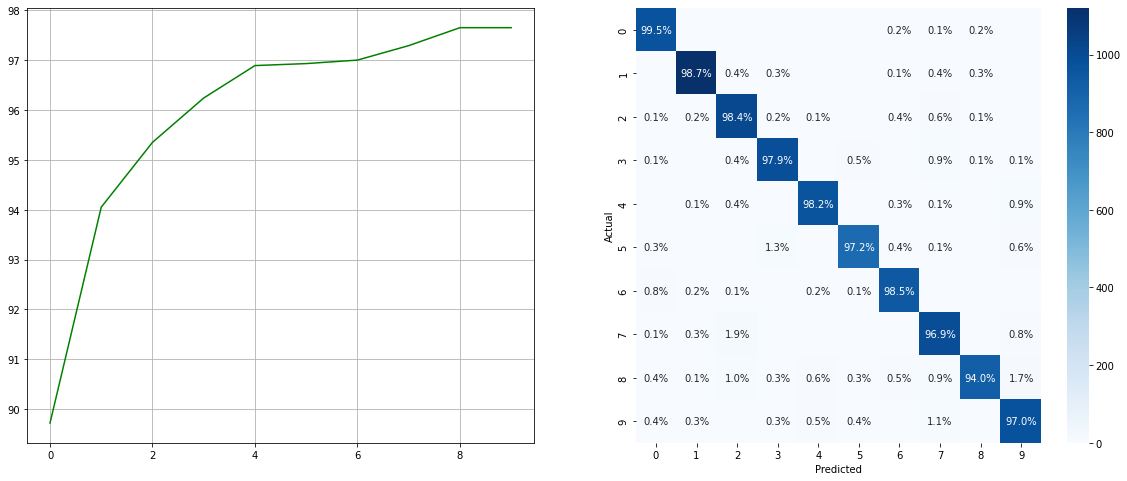

In [65]:
process(imbalanced_train_loader, test_loader, ClassDifficultyBalancedLoss)